### 目标
$\min f_1=x_1^2/4$ \
$\min f_2=x_1(1-x_2)+5$\
s.t. $\{ 1\le x_1 \le 4 $\, $1\le x_2 \le 2$\
$\{M,T,p_c,p_m \} = \{100,100,0.8,0.01  \} $

	

##### 二进制编码与解码

In [46]:
import random
import numpy as np
import matplotlib.pyplot as plt
def encode(x, lower_bound, upper_bound, bits=8):
    """将实数x编码为长度为bits的二进制字符串，范围在[lower_bound, upper_bound]"""
    max_int = 2**bits - 1
    int_value = int((x - lower_bound) / (upper_bound - lower_bound) * max_int)
    binary_str = format(int_value, f'0{bits}b')
    return binary_str
def decode(binary_str, lower_bound, upper_bound, bits=8):
    """将二进制字符串解码为实数"""
    max_int = 2**bits - 1
    int_value = int(binary_str, 2)
    return lower_bound + (upper_bound - lower_bound) * int_value / max_int

##### 评估函数,使用自身函数值

In [47]:
def evaluate(individual):
    x1_bin, x2_bin = individual[:8], individual[8:]
    x1 = decode(x1_bin, 1, 4)  # 解码x1，范围[1, 4]
    x2 = decode(x2_bin, 1, 2)  # 解码x2，范围[1, 2]
    f1 = (x1 ** 2) / 4  # 目标函数 f1
    f2 = x1 * (1 - x2) + 5  # 目标函数 f2
    return f1, f2

##### 初始化种群

In [48]:
def init_population(pop_size):
    population = []
    for _ in range(pop_size):
        x1 = encode(random.uniform(1, 4), 1, 4)  # 随机生成 x1 的二进制编码
        x2 = encode(random.uniform(1, 2), 1, 2)  # 随机生成 x2 的二进制编码
        individual = x1 + x2  # 将两个二进制串拼接为一个个体
        population.append(individual)
    return population

##### 单点交叉算子

In [49]:
def crossover(parent1, parent2):
    point = random.randint(1, len(parent1) - 1)  # 随机选择交叉点
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]
    return child1, child2

##### 基本位变异算子

In [50]:
def mutate(individual, mutation_rate=0.01):
    individual = list(individual)  # 将字符串转为列表以便修改
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            # 基本位变异：反转二进制位
            individual[i] = '1' if individual[i] == '0' else '0'
    return ''.join(individual)

##### 随机均分与合并

In [51]:
def population_split(full_list, ratio, shuffle=False):
    """
    数据集拆分: 将列表full_list按比例ratio(随机)划分为2个子列表sublist_1与sublist_2
    :param full_list: 数据列表
    :param ratio:     子列表1
    :param shuffle:   子列表2
    :return:
    """
    n_total = len(full_list)
    offset = int(n_total * ratio)
    if n_total == 0 or offset < 1:
        return [], full_list
    if shuffle:
        random.shuffle(full_list)
    sublist_1 = full_list[:offset]
    sublist_2 = full_list[offset:]

    return sublist_1, sublist_2
def population_merge(sublist_1, sublist_2):
    """合并两个子列表"""
    return sublist_1 + sublist_2

#####子目标排序

In [52]:
def subpareto_sort1(population):  #子目标1排序
    subpareto_front1 = []
    for i, ind1 in enumerate(population):
        dominated = False
        for j, ind2 in enumerate(population):
            if evaluate(ind2)[0] < evaluate(ind1)[0]:
                dominated = True
                break
        if not dominated:
            subpareto_front1.append(ind1)
    return subpareto_front1
def subpareto_sort2(population):  #子目标2排序
    subpareto_front2 = []
    for i, ind1 in enumerate(population):
        dominated = False
        for j, ind2 in enumerate(population):
            if evaluate(ind2)[1] < evaluate(ind1)[1]:
                dominated = True
                break
        if not dominated:
            subpareto_front2.append(ind1)
    return subpareto_front2


##### Pareto支配判定

In [53]:
def dominates(ind1, ind2): # 判断ind1是否优于ind2
    f1_1, f1_2 = evaluate(ind1)
    f2_1, f2_2 = evaluate(ind2)
    return (f1_1 <= f2_1 and f1_2 <= f2_2) and (f1_1 < f2_1 or f1_2 < f2_2)

##### Pareto排序

In [54]:
def pareto_sort(population):
    pareto_front = []
    for i, ind1 in enumerate(population):
        dominated = False
        for j, ind2 in enumerate(population):
            if dominates(ind2, ind1):
                dominated = True
                break
        if not dominated:
            pareto_front.append(ind1)
    return pareto_front


##### 轮盘赌基于Pareto排序的个体选择

In [55]:
def select1(population, num_to_select):  #子目标1选择
    selected1 = []
    subpareto_front1 = subpareto_sort1(population)
    while len(selected1) < num_to_select:
        selected1.append(random.choice(subpareto_front1))
    return selected1
def select2(population, num_to_select):  #子目标2选择
    selected2 = []
    subpareto_front2 = subpareto_sort2(population)
    while len(selected2) < num_to_select:
        selected2.append(random.choice(subpareto_front2))
    return selected2

##### Pareto Individuals

In [56]:
def pareto_individuals(population):
    pareto_individuals_front = []
    while len(population) > 0:
        pareto_front = pareto_sort(population)
        pareto_individuals_front.extend(pareto_front)
        population = [ind for ind in population if ind not in pareto_front]
    return pareto_individuals_front


##### Tournament Sharing Selection

In [57]:
def sharing_function(distance, sigma_share):
    alpha = 1  # 通常取值为1
    if distance < sigma_share:
        return 1 - (distance / sigma_share)**alpha
    else:
        return 0
#海明距离
def distance(bin_str1,bin_str2 ):
    count=0
    for i in range(len(bin_str1)):
        if bin_str1[i]!=bin_str2[i]:
            count+=1
    return count
# 小生境数
def NicheCount(individual, population, sigma_share):
    return sum(sharing_function(distance(individual, ind), sigma_share) for ind in population)
    
  
# Tournament Sharing Selection
def ts_selection(population,tournament_size,sigma_share):
    # 从群体中选择k个体进行锦标赛
  C = random.sample(population, tournament_size)
  # 从群体中选择2个体组成T
  T = random.sample(population, 2)
  # 选择适应度最高的个体
  dominated1= False
  dominated2 = False
  for i in range(tournament_size):
    if dominates(T[0], C[i]):
      dominated1 = True
      break
  for i in range(tournament_size):
    if dominates(T[1], C[i]):
      dominated2 = True
      break

  if dominated1 and (not dominated2):
    return T[1]
  elif (not dominated1) and dominated2:
    return T[0]
  else:
    if NicheCount(T[0], population, sigma_share) < NicheCount(T[1], population, sigma_share):
      return T[0]
    else:
      return T[1]

    
  
  





##### 轮盘赌选择基于Pareto排序的个体

In [58]:
def select(population, num_to_select):
    selected = []
    pareto_front = pareto_sort(population)
    while len(selected) < num_to_select:
        selected.append(random.choice(pareto_front))
    return selected


##### 可视化Pareto前沿解

In [59]:
def plot_pareto_front(pareto_front):
    f1_vals, f2_vals = [], []
    for ind in pareto_front:
        f1, f2 = evaluate(ind)
        f1_vals.append(f1)
        f2_vals.append(f2)

    plt.scatter(f1_vals, f2_vals, color='blue', label='Pareto front')
    plt.title('mixture Pareto front')
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    plt.xlabel('f1')
    plt.ylabel('f2')
    plt.legend()
    plt.grid(True)
    plt.savefig('mixture.eps', format='eps')
    plt.show()

##### 主算法

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Final Pareto front solutions:
Solution: 1111111111111111, Objectives: (4.0, 1.0)
Solution: 1111111111111111, Objectives: (4.0, 1.0)
Solution: 1111111111111111, Objectives: (4.0, 1.0)
Solution: 1111111111111111, Objectives: (4.0, 1.0)
Solution: 1111111111111111, Objectives: (4.0, 1.0)
Solution: 1111111111111111, Objectives: (4.0, 1.0)
Solution: 1111111111111111, Objectives: (4.0, 1.0)
Solution: 1011111111111111, Objectives: (2.635847750865052, 1.7529411764705882)
Solution: 1111111111111111, Objectives: (4.0, 1.0)
Solution: 0000000001000000, Objectives: (0.25, 4.749019607843137)
Solution: 1111111111111111, Objectives: (4.0, 1.0)
Solution: 1111111111111111, Objectives: (4.0, 1.0)
Solution: 1111111111111111, Objectives: (4.0, 1.0)
Solution: 1111111111111111, Objectives: (4.0, 1.0)
Solution: 1111111111111111, Objectives: (4.0, 1.0)
Solution: 1111111111111111, Objectives: (4.0, 1.0)
Solution: 1111111111111111, Objectives: (4.0, 1.0)
Solution: 0111111111111111, Objectives: (1.555155709342560

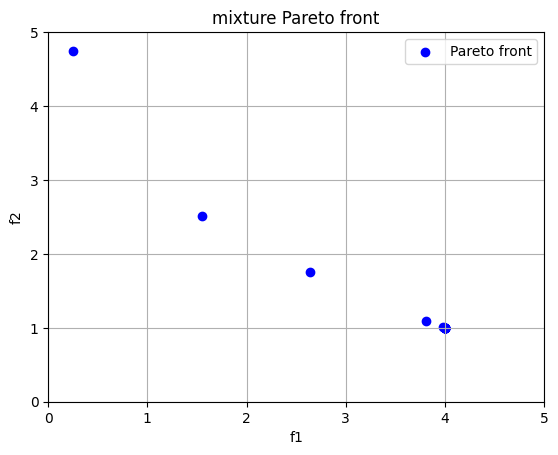

In [60]:
def main():
    pop_size = 100  # 种群大小
    generations = 100  # 代数
    crossover_rate = 0.8  # 交叉概率
    mutation_rate = 0.01  # 变异概率

    # 初始化种群
    population = init_population(pop_size)

    for gen in range(generations):
        new_population = []
    # 并列选择过程
        population1,population2=population_split(population,0.5,shuffle=True)
        selected1 = select1(population1, 40)
        selected2 = select2(population2, 40)
        selected = selected1 + selected2

        # 交叉操作
        for i in range(0, 80, 2):
            if random.random() < crossover_rate:
                parent1, parent2 = selected[i], selected[i+1]
                child1, child2 = crossover(parent1, parent2)
                new_population.extend([child1, child2])
            else:
                new_population.extend([selected[i], selected[i+1]])

        
    #保留Pareto最优个体过程
        new_population.extend(subpareto_sort1(selected1))
        new_population.extend(subpareto_sort2(selected2))
    #共享函数处理过程
        if len(new_population)>pop_size:
            new_population_ = []
            for i in range(pop_size):
                new_population_.append(ts_selection(new_population,2,0.8))
            new_population = new_population_
            

    # 变异操作
        for i in range(len(new_population)):
            new_population[i] = mutate(new_population[i], mutation_rate)
        # 更新种群
        population = new_population

         # 获取最终帕累托前沿解
    pareto_front = pareto_sort(population)
    
    # 输出帕累托前沿解并绘制分布图
    print("\nFinal Pareto front solutions:")
    for ind in pareto_front:
        print(f"Solution: {ind}, Objectives: {evaluate(ind)}")

    # 绘制帕累托前沿解分布
    plot_pareto_front(pareto_front)

if __name__ == "__main__":
    main()